# LSTM (Hochreiter and Schmidhuber 1997, Graves' 2000 version including forget gate) applied to sMNIST
## This code uses flax.linen.scan to speed up the loop over time

## Equations
State update:

$
\vec{f}_t = \sigma(W_{xf}\vec{x}_t + W_{hf}\vec{h}_{t-1} + \vec{b}_f) \\
\vec{i}_t = \sigma(W_{xi}\vec{x}_t + W_{hi}\vec{h}_{t-1} + \vec{b}_i) \\
\vec{o}_t = \sigma(W_{xo}\vec{x}_t + W_{ho}\vec{h}_{t-1} + \vec{b}_o) \\
\vec{\hat{x}}_t = \tanh(W_{x}\vec{x}_t + W_{h}\vec{h}_{t-1} + \vec{b}_x) \\
\vec{c}_t = \vec{f}_t \odot \vec{c}_{t-1} + \vec{i}_t \odot \vec{\hat{x}}_t \\
\vec{h}_t = \vec{o}_t \odot \tanh(\vec{c}_t) \\
$

Output: mean of output over time (or cummulative sum of output over time):

$
\vec{o}_t = W_{hy}\vec{h}_t + \vec{b}_o \\
\vec{o} = \frac{1}{T}\sum_{t=1}^{T}\vec{o}_t \\
\vec{y} = \text{softmax}(\vec{o}) \\
$

In [1]:
!pwd
!which python
!pip freeze | grep -E 'flax|jax|orbax|optax'

/home/tristan/LearningJAX/Flax
/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/bin/python
flax==0.8.0
jax==0.4.25
jaxlib==0.4.25+cuda11.cudnn86
optax==0.1.8
orbax-checkpoint==0.5.0


In [2]:
import jax
import numpy as np
import torch
from jax import numpy as jnp
from torch.utils.data import TensorDataset
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
from flax import linen as nn
from flax.training import train_state
import optax
from jax.nn.initializers import lecun_normal
from typing import Any, Tuple, Sequence, Optional
import matplotlib.pyplot as plt
px = 1 / plt.rcParams['figure.dpi']

jnp.set_printoptions(precision=3, suppress=True)

# set cuda visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from utils import create_mnist_classification_dataset, plot_dynamics

In [4]:
DATASET_VERSION = 'sequential'
HIDDEN_DIM = 256
trainloader, val_loader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM = create_mnist_classification_dataset(root="../data", version=DATASET_VERSION)

[*] Generating MNIST Classification Dataset...


In [5]:
batch_x, batch_y = next(iter(testloader))
print(batch_x.shape, batch_y.shape)
print(batch_y.dtype)

(128, 784, 1) (128,)
int64


In [32]:
from typing import Sequence

def identity_weight_init():
    def init(key, shape, dtype=jnp.float32):
        w = jnp.eye(shape[0], shape[1], dtype=dtype) * 0.9
        w = w.at[-1, :].set(1.0)
        return w
    return init

class LSTMLayer(nn.Module):
    hidden_size: int
    output_size: int

    @nn.compact
    def __call__(self, x):

        scan_update = nn.scan(
            nn.OptimizedLSTMCell,
            variable_broadcast='params',
            split_rngs={'params': False},
            in_axes=0,
            out_axes=0,
        )
        lstm = scan_update(self.hidden_size)
        carry = lstm.initialize_carry(jax.random.PRNGKey(0), (x.shape[0],)) # carry = (h, c) with h and c of shape (hidden_size,)
        carry, x = lstm(carry, x) # carry = (h, c) with h and c of shape (hidden_size,), x = (n_timesteps, hidden_size)
        return x

class RNNBackbone(nn.Module):
    hidden_size: int
    output_size: int
    n_layers: int
    recurrent_layer: nn.Module = LSTMLayer

    @nn.compact
    def __call__(self, x):
        state_hist = []
        for _ in range(self.n_layers-1):
            x = self.recurrent_layer(self.hidden_size, self.output_size)(x)
            state_hist.append(x)
        x = self.recurrent_layer(self.hidden_size, self.output_size)(x)
        state_hist.append(x)
        out = nn.Dense(self.output_size, name='Dense_Out')(x)
        return state_hist, out
    
BatchRNN = nn.vmap(RNNBackbone, in_axes=0, out_axes=0, variable_axes={'params': None}, split_rngs={'params': False})


In [7]:
model = BatchRNN(HIDDEN_DIM, 10, 1)
params = model.init(jax.random.PRNGKey(0), jnp.zeros_like(batch_x[:5]))
state_hist, out_hist = model.apply(params, batch_x[:5]+1)
print(len(state_hist), len(state_hist[0]), state_hist[0][0].shape, out_hist.shape) # (batch, time, cell_size)
y = out_hist.mean(axis=1)
print(y.shape)
assert y.shape == (5, 10)
print(y)

1 5 (784, 256) (5, 784, 10)
(5, 10)
[[-0.032 -0.047 -0.028  0.085 -0.008 -0.013  0.013 -0.008 -0.023  0.023]
 [-0.04  -0.059 -0.04   0.122 -0.003 -0.014  0.018 -0.012 -0.032  0.039]
 [-0.024 -0.034 -0.018  0.051 -0.01  -0.012  0.009 -0.005 -0.013  0.013]
 [-0.048 -0.072 -0.048  0.149 -0.004 -0.017  0.023 -0.016 -0.037  0.051]
 [-0.04  -0.057 -0.033  0.094 -0.013 -0.019  0.015 -0.009 -0.024  0.025]]


In [8]:
one_hot = jax.nn.one_hot(batch_y[:5], 10)
loss = optax.softmax_cross_entropy(logits=y, labels=one_hot)
print(loss.shape)
print(loss)
print(loss.mean())


(5,)
[2.308 2.342 2.333 2.35  2.31 ]
2.3285627


In [9]:
print('\nparams: \n', jax.tree_util.tree_map(jnp.shape, params['params']))


params: 
 {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'LSTMLayer_0': {'ScanOptimizedLSTMCell_0': {'hf': {'bias': (256,), 'kernel': (256, 256)}, 'hg': {'bias': (256,), 'kernel': (256, 256)}, 'hi': {'bias': (256,), 'kernel': (256, 256)}, 'ho': {'bias': (256,), 'kernel': (256, 256)}, 'if': {'kernel': (1, 256)}, 'ig': {'kernel': (1, 256)}, 'ii': {'kernel': (1, 256)}, 'io': {'kernel': (1, 256)}}}}


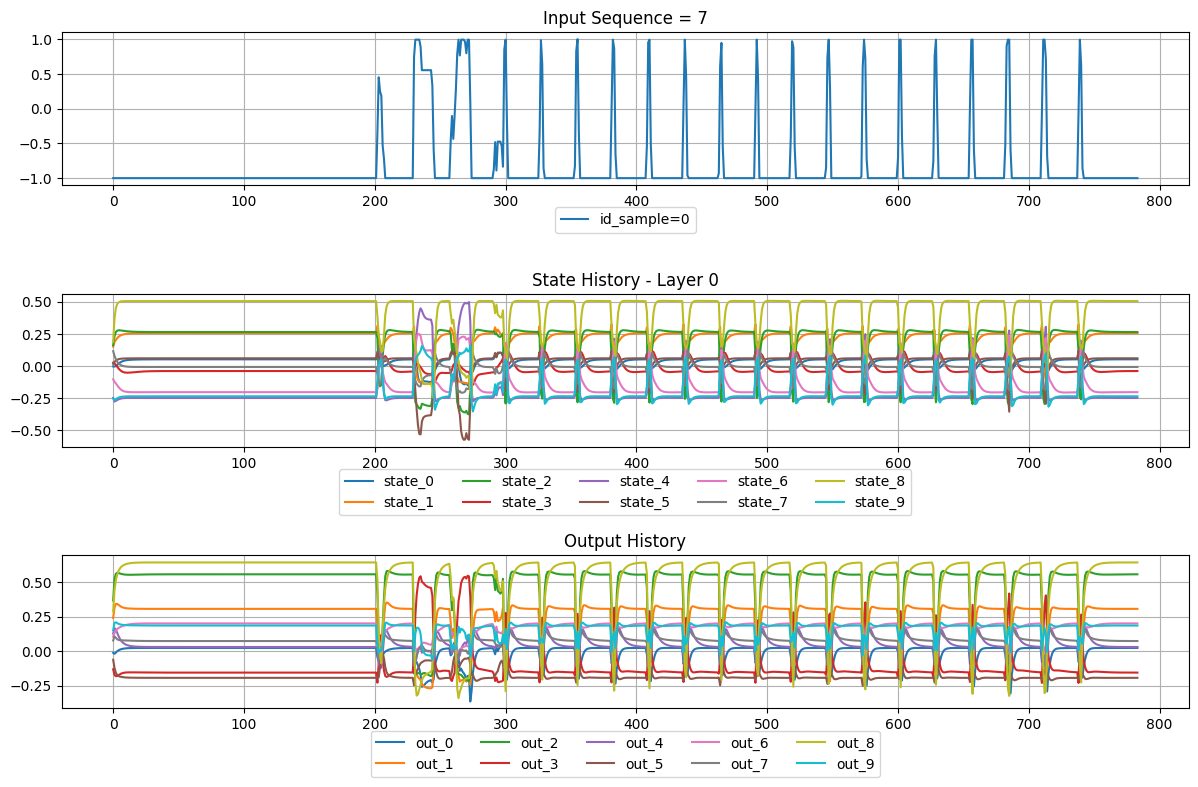

In [10]:
plot_dynamics(model, params, batch_x, batch_y, dataset_version=DATASET_VERSION, id_sample=0, nb_components_to_plot=10, 
              model_type='optimized_lstm')

1
2
(5, 784, 256)


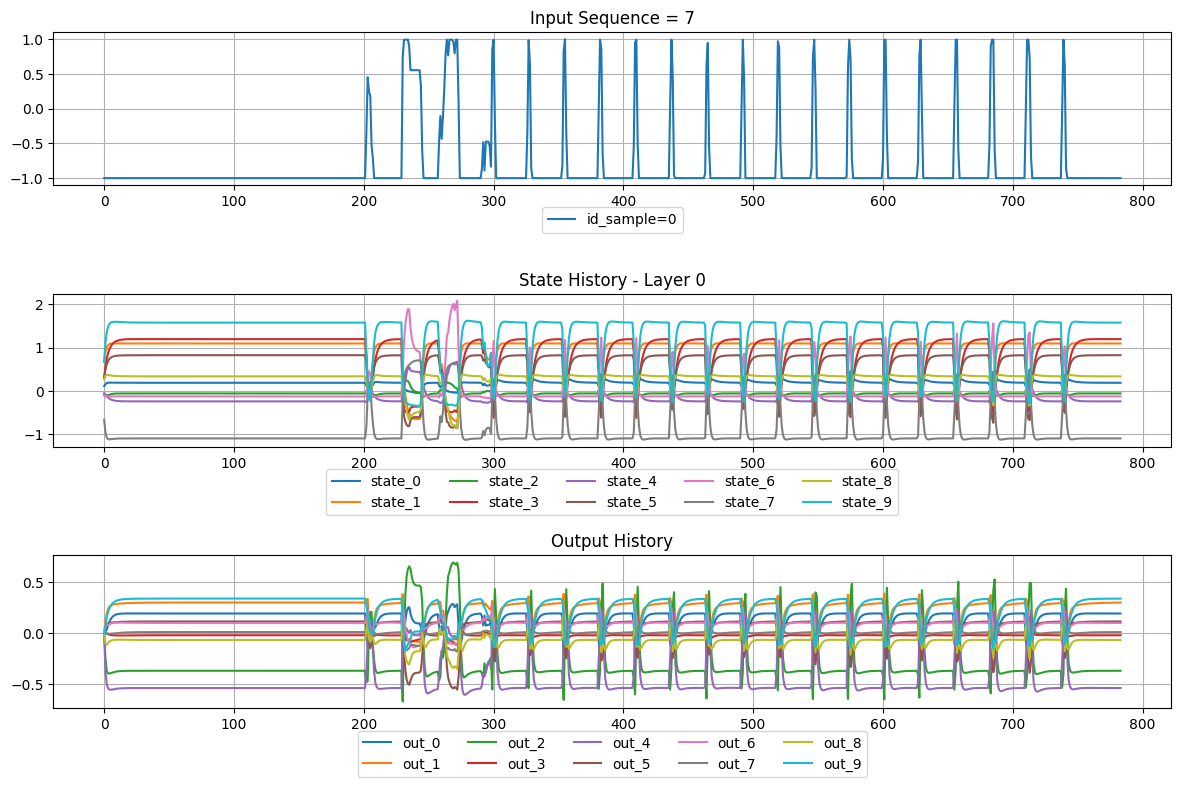

In [11]:
plot_dynamics(model, params, batch_x, batch_y, dataset_version=DATASET_VERSION, id_sample=0, nb_components_to_plot=10, 
              model_type='lstm', variable_to_plot='c')

In [11]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
lr = 1e-3

In [12]:
@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

In [13]:
@jax.jit
def apply_model(state, images, labels):
    """Computes gradients, loss and accuracy for a single batch."""

    def loss_fn(params):
        _, out_hist = state.apply_fn({'params': params}, images)
        logits = out_hist.mean(axis=1)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy
    

In [14]:
def run_epoch(state, train_dl, rng):
    """Train for a single epoch."""

    epoch_loss = []
    epoch_accuracy = []

    progress_bar = tqdm(train_dl, desc="Training", leave=True)
    batch_id = 0
    for batch_images, batch_labels in progress_bar:
        grads, loss, accuracy = apply_model(state, batch_images, batch_labels)
        # print(jnp.max(grads['dense_0']['kernel']), jnp.min(grads['dense_0']['kernel']))
        # print(loss)
        state = update_model(state, grads)
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)
        batch_id += 1
        if batch_id % 3 == 0:
            progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy.item())
        
    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)
    return state, train_loss, train_accuracy


In [15]:
@jax.jit
def eval_model(state, images, labels):
    """Computes gradients, loss and accuracy for a single batch."""

    def loss_fn(params):
        _, out_hist = state.apply_fn({'params': params}, images)
        logits = out_hist.mean(axis=1)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    loss, logits = loss_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return loss, accuracy

In [16]:
def validate(state, testloader):
    # Compute average loss & accuracy
    # model = model(training=False) # needed when using dropout
    losses, accuracies = [], []
    for batch_idx, (inputs, labels) in enumerate(testloader):
        loss, acc = eval_model(
            state, inputs, labels # from S4D: , model, classification=classification
        )
        losses.append(loss)
        accuracies.append(acc)
    return np.mean(losses), np.mean(accuracies)


In [17]:
def map_nested_fn(fn):
    """Recursively apply `fn to the key-value pairs of a nested dict / pytree."""

    def map_fn(nested_dict):
        return {
            k: (map_fn(v) if hasattr(v, "keys") else fn(k, v))
            for k, v in nested_dict.items()
        }

    return map_fn

def create_train_state(key, model_cls, lr, dataset_version, hidden_size, n_layers):
    
    init_x = jnp.ones((128, 784, 1)) if dataset_version == "sequential" else jnp.ones((128, 28, 28))

    model = model_cls(hidden_size=hidden_size, output_size=10, n_layers=n_layers)
    params = model.init(key, init_x)['params']
    
    # Debugging: Print parameter structure
    print("Initialized parameter structure:", jax.tree_util.tree_map(jnp.shape, params))

    param_sizes = map_nested_fn(
        lambda k, param: param.size
        # if lr_layer.get(k, lr) > 0.0
        # else 0
    )(params)
    print(f"[*] Trainable Parameters: {sum(jax.tree_util.tree_leaves(param_sizes))}")

    optimizer = optax.adam(lr)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )

In [18]:
state = create_train_state(key, BatchRNN, lr, DATASET_VERSION, 256, 1)

Initialized parameter structure: {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'LSTMLayer_0': {'ScanOptimizedLSTMCell_0': {'hf': {'bias': (256,), 'kernel': (256, 256)}, 'hg': {'bias': (256,), 'kernel': (256, 256)}, 'hi': {'bias': (256,), 'kernel': (256, 256)}, 'ho': {'bias': (256,), 'kernel': (256, 256)}, 'if': {'kernel': (1, 256)}, 'ig': {'kernel': (1, 256)}, 'ii': {'kernel': (1, 256)}, 'io': {'kernel': (1, 256)}}}}
[*] Trainable Parameters: 266762


In [19]:
for epoch in range(5):
    key, subkey = jax.random.split(key) # not used in run_epoch (TODO: remove?)
    state, train_loss, train_accuracy = run_epoch(state, trainloader, key)
    val_loss, val_acc  = validate(state, val_loader)
    print(f"Epoch {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_accuracy*100:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc*100:.2f}%")

Training: 100%|██████████| 390/390 [00:23<00:00, 16.79it/s, accuracy=0.438, loss=1.68]


Epoch 0 | train_loss: 1.9395 | train_acc: 32.48% | val_loss: 1.6504 | val_acc: 48.29%


Training: 100%|██████████| 390/390 [00:22<00:00, 17.34it/s, accuracy=0.258, loss=1.76]


Epoch 1 | train_loss: 2.1458 | train_acc: 24.34% | val_loss: 1.7967 | val_acc: 34.43%


Training: 100%|██████████| 390/390 [00:22<00:00, 17.40it/s, accuracy=0.469, loss=1.56]


Epoch 2 | train_loss: 1.7373 | train_acc: 37.84% | val_loss: 1.5191 | val_acc: 50.51%


Training: 100%|██████████| 390/390 [00:22<00:00, 17.46it/s, accuracy=0.539, loss=1.36]


Epoch 3 | train_loss: 1.4021 | train_acc: 53.07% | val_loss: 1.3684 | val_acc: 52.90%


Training: 100%|██████████| 390/390 [00:22<00:00, 17.29it/s, accuracy=0.625, loss=1.16] 


Epoch 4 | train_loss: 1.1030 | train_acc: 64.06% | val_loss: 1.0441 | val_acc: 67.72%


# <font color='red'>TO DO: ADAPT PLOTTING FUNCTIONS.</font>

In [23]:
print(jax.tree_util.tree_map(jnp.shape, params['params']))
print(jax.tree_util.tree_map(jnp.shape, state.params))

{'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'LSTMLayer_0': {'ScanOptimizedLSTMCell_0': {'hf': {'bias': (256,), 'kernel': (256, 256)}, 'hg': {'bias': (256,), 'kernel': (256, 256)}, 'hi': {'bias': (256,), 'kernel': (256, 256)}, 'ho': {'bias': (256,), 'kernel': (256, 256)}, 'if': {'kernel': (1, 256)}, 'ig': {'kernel': (1, 256)}, 'ii': {'kernel': (1, 256)}, 'io': {'kernel': (1, 256)}}}}
{'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'LSTMLayer_0': {'ScanOptimizedLSTMCell_0': {'hf': {'bias': (256,), 'kernel': (256, 256)}, 'hg': {'bias': (256,), 'kernel': (256, 256)}, 'hi': {'bias': (256,), 'kernel': (256, 256)}, 'ho': {'bias': (256,), 'kernel': (256, 256)}, 'if': {'kernel': (1, 256)}, 'ig': {'kernel': (1, 256)}, 'ii': {'kernel': (1, 256)}, 'io': {'kernel': (1, 256)}}}}


In [24]:
# fig, axs = plt.subplots(2, 5, figsize=(1200*px, 600*px), sharex=True)
# axs[0,0].hist(params['params']['Dense_Out']['kernel'].flatten(), bins=100)
# axs[0,1].hist(params['params']['ScanOptimizedLSTMCell_0']['Dense_x']['kernel'].flatten(), bins=100)
# axs[0,2].hist(params['params']['ScanOptimizedLSTMCell_0']['Dense_h']['kernel'].flatten(), bins=100)
# axs[0,3].hist(params['params']['ScanOptimizedLSTMCell_0']['Dense_x']['bias'].flatten(), bins=100)
# axs[0,4].hist(params['params']['ScanOptimizedLSTMCell_0']['Dense_h']['bias'].flatten(), bins=100)
# axs[1,0].hist(state.params['Dense_Out']['kernel'].flatten(), bins=100)
# axs[1,1].hist(state.params['ScanOptimizedLSTMCell_0']['Dense_x']['kernel'].flatten(), bins=100)
# axs[1,2].hist(state.params['ScanOptimizedLSTMCell_0']['Dense_h']['kernel'].flatten(), bins=100)
# axs[1,3].hist(state.params['ScanOptimizedLSTMCell_0']['Dense_x']['bias'].flatten(), bins=100)
# axs[1,4].hist(state.params['ScanOptimizedLSTMCell_0']['Dense_h']['bias'].flatten(), bins=100)
# plt.tight_layout()
# plt.show()

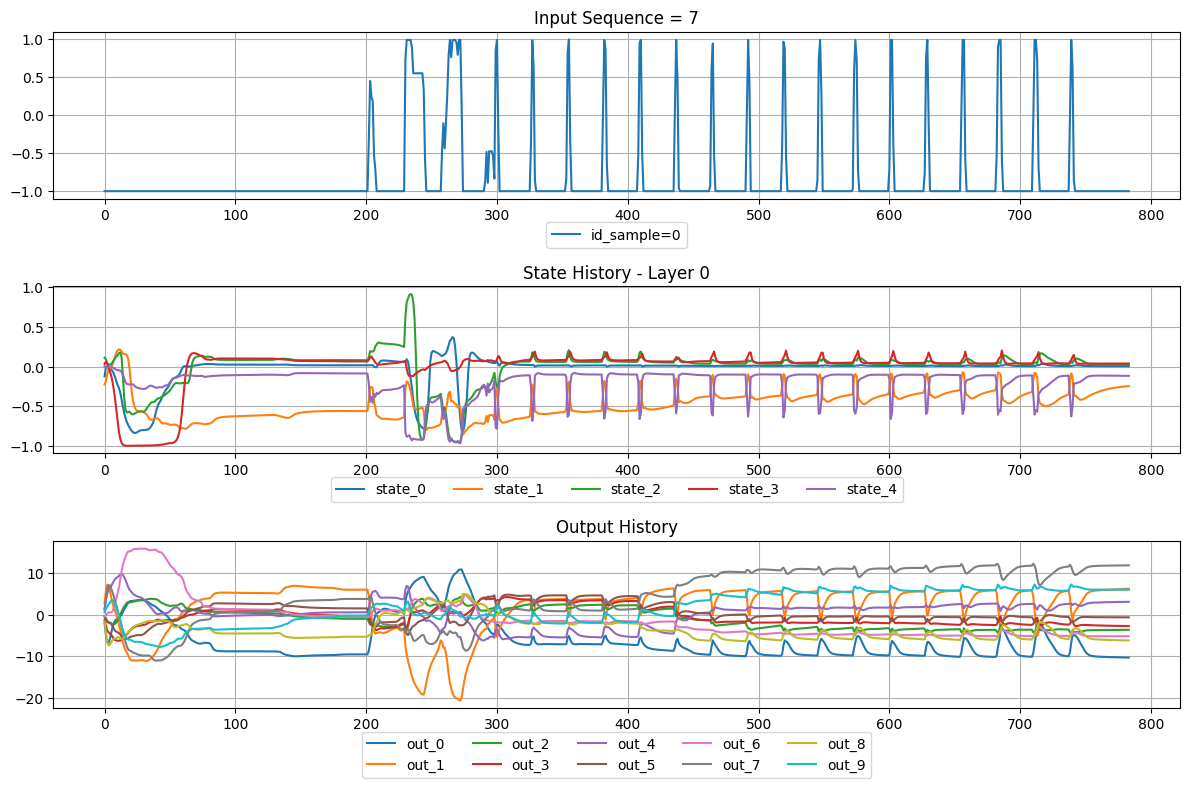

In [26]:
plot_dynamics(model, state.params, batch_x, batch_y, dataset_version=DATASET_VERSION, id_sample=0, model_type='optimized_lstm')

In [27]:
all_state_hist, out_hist = model.apply({'params':state.params}, batch_x[:5])
print(len(all_state_hist), len(all_state_hist[0]), all_state_hist[0][0].shape, out_hist.shape) # (batch, time, cell_size)

1 5 (784, 256) (5, 784, 10)


In [28]:
y = out_hist.mean(axis=1)
print(y.shape)
assert y.shape == (5, 10)
print(y)

(5, 10)
[[-6.209  1.888 -0.887 -0.433  0.319  0.505 -1.08   4.436 -3.561  1.659]
 [-3.14  -0.461  2.606  2.536 -3.056  1.786  1.248 -1.794 -1.017 -2.458]
 [-6.813  4.987  1.154  0.908 -0.737  1.347  1.53  -0.27  -3.61  -2.387]
 [ 2.414 -6.213  0.32   0.181 -0.511 -0.604  0.872 -3.931  2.421  0.234]
 [-0.642 -2.308 -2.219 -1.956  2.982 -1.679  0.397 -1.232  0.084  1.875]]


In [29]:
one_hot = jax.nn.one_hot(batch_y[:5], 10)
loss = optax.softmax_cross_entropy(logits=y, labels=one_hot)
print(loss.shape)
print(loss)
print(loss.mean())

(5,)
[0.177 1.003 0.1   0.982 0.425]
0.5374735


# Multi Layer (3 hidden, 1 output) 
## This code uses flax.linen.scan to speed up the loop over time

## Equations
The output of a LSTM layer is $

In [33]:
DATASET_VERSION = 'sequential'
HIDDEN_DIM = 256
trainloader, val_loader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM = create_mnist_classification_dataset(root="../data", version=DATASET_VERSION)

[*] Generating MNIST Classification Dataset...


In [34]:
model = BatchRNN(HIDDEN_DIM, 10, 3)
state = create_train_state(key, BatchRNN, lr, DATASET_VERSION, HIDDEN_DIM, 3)

Initialized parameter structure: {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'LSTMLayer_0': {'ScanOptimizedLSTMCell_0': {'hf': {'bias': (256,), 'kernel': (256, 256)}, 'hg': {'bias': (256,), 'kernel': (256, 256)}, 'hi': {'bias': (256,), 'kernel': (256, 256)}, 'ho': {'bias': (256,), 'kernel': (256, 256)}, 'if': {'kernel': (1, 256)}, 'ig': {'kernel': (1, 256)}, 'ii': {'kernel': (1, 256)}, 'io': {'kernel': (1, 256)}}}, 'LSTMLayer_1': {'ScanOptimizedLSTMCell_0': {'hf': {'bias': (256,), 'kernel': (256, 256)}, 'hg': {'bias': (256,), 'kernel': (256, 256)}, 'hi': {'bias': (256,), 'kernel': (256, 256)}, 'ho': {'bias': (256,), 'kernel': (256, 256)}, 'if': {'kernel': (256, 256)}, 'ig': {'kernel': (256, 256)}, 'ii': {'kernel': (256, 256)}, 'io': {'kernel': (256, 256)}}}, 'LSTMLayer_2': {'ScanOptimizedLSTMCell_0': {'hf': {'bias': (256,), 'kernel': (256, 256)}, 'hg': {'bias': (256,), 'kernel': (256, 256)}, 'hi': {'bias': (256,), 'kernel': (256, 256)}, 'ho': {'bias': (256,), 'kernel': (256, 25

In [35]:
for epoch in range(5):
    key, subkey = jax.random.split(key) # not used in run_epoch (TODO: remove?)
    state, train_loss, train_accuracy = run_epoch(state, trainloader, key)
    val_loss, val_acc  = validate(state, val_loader)
    print(f"Epoch {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_accuracy*100:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc*100:.2f}%")

Training: 100%|██████████| 390/390 [01:08<00:00,  5.72it/s, accuracy=0.148, loss=2.29] 


Epoch 0 | train_loss: 2.2420 | train_acc: 19.50% | val_loss: 2.2878 | val_acc: 13.64%


Training: 100%|██████████| 390/390 [01:05<00:00,  5.97it/s, accuracy=0.695, loss=0.946]


Epoch 1 | train_loss: 1.6216 | train_acc: 43.97% | val_loss: 4.0472 | val_acc: 17.61%


Training: 100%|██████████| 390/390 [01:05<00:00,  5.96it/s, accuracy=0.844, loss=0.467]


Epoch 2 | train_loss: 0.6078 | train_acc: 80.33% | val_loss: 0.5600 | val_acc: 81.13%


Training: 100%|██████████| 390/390 [01:05<00:00,  5.96it/s, accuracy=0.891, loss=0.426]


Epoch 3 | train_loss: 0.5476 | train_acc: 82.27% | val_loss: 0.4601 | val_acc: 84.93%


Training: 100%|██████████| 390/390 [01:05<00:00,  5.97it/s, accuracy=0.898, loss=0.298]


Epoch 4 | train_loss: 0.3926 | train_acc: 86.90% | val_loss: 0.3271 | val_acc: 89.17%


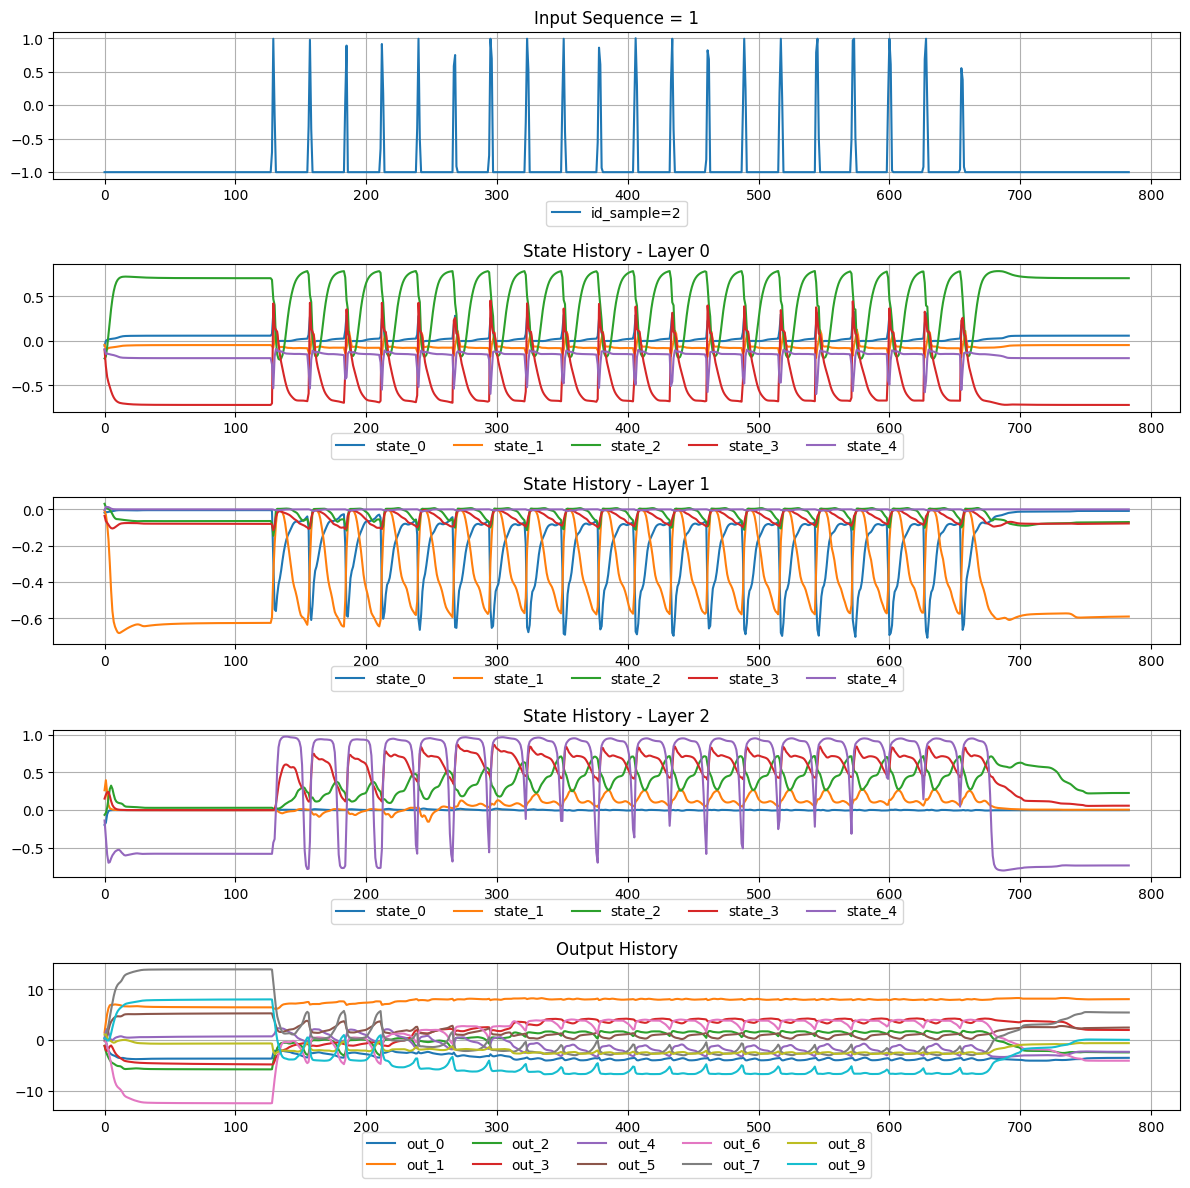

In [36]:
plot_dynamics(model, state.params, batch_x, batch_y, dataset_version=DATASET_VERSION, id_sample=2, model_type='optimized_lstm')